In [1]:
#load package
using Revise
using Plots
using LaTeXStrings
using LinearAlgebra
using SparseIR
using Nevanlinna

[ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]


In [2]:
# Set work data Type
T = BigFloat
setprecision(128)
;

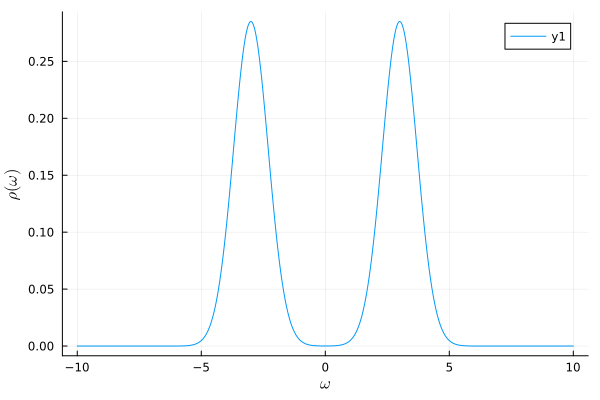

In [3]:
#define spectral function
gaussian(x, mu, sigma) = exp(-0.5*((x-mu)/sigma)^2)/(sqrt(2*π)*sigma)
rho(omega) = 0.5*gaussian(omega, -3.0, 0.7) + 0.5*gaussian(omega, 3.0, 0.7)
omegas = LinRange(-10, 10, 1000)
plot()
plot!(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
function generate_input_data(rho::Function, beta::Float64)
    lambda = 1e+4
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

    rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
    gl = - basis.basis_f.s .* rhol
    gw = evaluate(basis.smpl_wn_f, gl)
    
    hnw = length(basis.smpl_wn_f.sampling_points)÷2
    
    input_smpl = Array{Complex{T}}(undef, hnw) 
    input_gw   = Array{Complex{T}}(undef, hnw) 
    
    for i in 1:hnw
        input_smpl[i]= SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], beta)
        input_gw[i]  = gw[hnw+i]
    end
    
    return input_smpl, input_gw
end

generate_input_data (generic function with 1 method)

In [5]:
beta = 10. #inverse temperature
input_smpl, input_gw = generate_input_data(rho, beta)
;

In [6]:
#cutoff = 32
#test_smpl = input_smpl[1:cutoff]
#test_gw = input_gw[1:cutoff]
;

In [7]:
N_real    = 1000  #demension of array of output
omega_max = 10.0  #energy cutoff of real axis
eta       = 0.001 #broaden parameter 
sum_rule  = 1.0   #sum rule
H_max     = 50    #cutoff of Hardy basis
lambda    = 1e-4  #regularization parameter
iter_tol  = 1000  #upper bound of iteration
#ini_iter_tol  = 5000  #upper bound of iteration
;

In [26]:
#construct solver struct
@time sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true)
#@time sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true,ini_tol=pick_iter_tol)
#@time sol = Nevanlinna.NevanlinnaSolver(test_smpl, test_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true)
;

N_imag is setted as 16
H=1
Iter     Function value   Gradient norm 
     0     4.045057e-02     8.545052e-02
 * time: 3.886222839355469e-5
     1     1.209219e-02     2.454538e-02
 * time: 0.21902799606323242
     2     8.114273e-03     9.659076e-03
 * time: 0.369520902633667
     3     7.747748e-03     1.053964e-02
 * time: 0.5171709060668945
     4     5.554965e-03     1.509449e-02
 * time: 0.7755100727081299
     5     2.842309e-03     2.023576e-03
 * time: 0.9276819229125977
     6     2.790523e-03     3.303857e-04
 * time: 1.0938050746917725
     7     2.788129e-03     6.726614e-05
 * time: 1.1822428703308105
     8     2.788069e-03     2.243944e-05
 * time: 1.2902910709381104
     9     2.788062e-03     4.413404e-06
 * time: 1.3960769176483154
    10     2.788062e-03     1.570580e-06
 * time: 1.5461249351501465
    11     2.788062e-03     3.686687e-07
 * time: 1.6490919589996338
    12     2.788062e-03     1.808685e-07
 * time: 1.756321907043457
    13     2.788062e-03     8.3893

In [27]:
#execute optimize
@time Nevanlinna.solve!(sol)

H=1
Iter     Function value   Gradient norm 
     0     2.788062e-03     6.583163e-09
 * time: 4.00543212890625e-5
max_theta=0.9234793538421512505206223822170759640307
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     2.788062e-03     4.430164e-03
 * time: 0.00018596649169921875
     1     2.490273e-03     3.121465e-03
 * time: 0.29372191429138184
     2     2.382211e-03     4.600532e-03
 * time: 0.5126938819885254
     3     1.681705e-03     2.872022e-03
 * time: 0.7514240741729736
     4     1.500242e-03     3.384778e-03
 * time: 0.921241044998169
     5     1.419945e-03     3.632780e-03
 * time: 1.1182379722595215
     6     1.384574e-03     3.847569e-03
 * time: 1.2155060768127441
     7     1.302663e-03     3.539574e-03
 * time: 1.4013638496398926
     8     1.176957e-03     2.447804e-03
 * time: 1.562964916229248
     9     1.099556e-03     7.315124e-04
 * time: 1.7318429946899414
    10     1.089553e-03     3.878929e-04
 * time: 1.8506748676

In [28]:
wo_sol = Nevanlinna.NevanlinnaSolver(test_smpl, test_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
;

LoadError: UndefVarError: test_smpl not defined

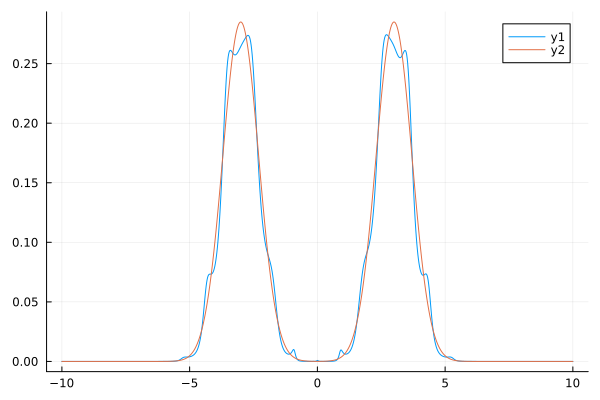

In [29]:
plot()
#plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi,marker=:+)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [12]:
plot(xlim = [-6,6],
    legend = :topright,
    #ymirror = true, 
    xticks = [5,0,-5],
    yticks = [0.3,0,-0.3],
    xtickfont=font(15), 
    ytickfont=font(15), 
    guidefont=font(25), 
    legendfont=font(20))
plot!(xlabel=latexstring("\\omega"))
plot!(ylabel=latexstring("\\rho"))
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val/pi),label="non-opt",lw=3)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val)/pi),label="opt",lw=3)
plot!(omegas, rho.(omegas), label="exact",lw=1.5,ls=:dash,lc=:black)
#savefig("two_peak.svg")

LoadError: UndefVarError: wo_sol not defined